<img src="./img/sktime-logo-text-horizontal.jpg" alt="sktime logo" style="width: 100%; max-width: 600px;">

# Type 1 Diabetes - Meal Identification Change Point Benchmark

## skchange challenge - developing semi-supervised change point detection methods and estimators

In this presentation we go over:
1. A time series data set generated by open source FDA approved T1D simulator
2. The details of the meal change point detection task, and why it's semi-supervised.
   - Full data set with example notebook found here: [https://github.com/Blood-Glucose-Control/t1d-change-point-detection-benchmark](https://github.com/Blood-Glucose-Control/t1d-change-point-detection-benchmark)
3. **A call to action**: `sktime` and `skchange` need semi-supervised detectors! We invite you to contribute existing or new detectors that you develop to the libraries. 

## Overview

In this challenge you will build change point detection models using data generated from FDA-approved [UVA/PADOVA Type 1 Diabetes Simulator](https://journals.sagepub.com/doi/10.1177/1932296813514502).

We use this simulator to create a semi-supervised change point detection setting
- the modeller must correctly predict the meal times from a blood glucose levels (bgl) time series 
- bgl are produced by the simulated continuous glucose monitor.

The challenge with this simulated scenario is that compared to real-world settings detailed meal logging occurs in a much noisier and infrequent fashion.  
In this challenge we modify the labels of the simulation results by:
- introducing noise around the meal logging time, and 
- completely erase a large percentage of labels to reflect real world logging habits. 

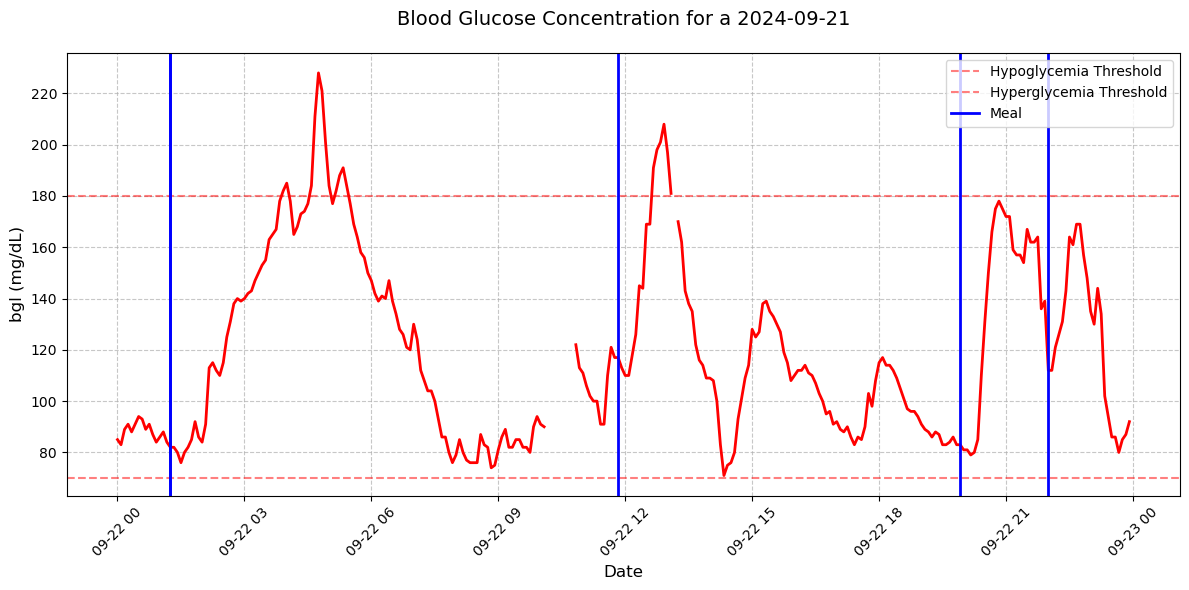

### Data set Description

- **date:** the time series data is resampled to 5-minute intervals
- **bgl_real:** the 'real' simulated blood glucose level inside the blood stream of the simulated t1d patient
- **bgl_cgm:** the simulated blood glucose level as read from the continuous glucose monitor sensor, reflecting real world cgm inaccuracies and noise.
- **meal_start_change_point:** the true start of a meal according the simulator, the change points that we are trying to identify. 
  - True change points:  `df[df['meal_start_change_point'] == 'ANNOUNCE_MEAL'].index`.
- **food_g:** the food that the t1d has consumed, for informational purposes only, not to be used in modelling. 

Each csv is includes data for 1 patient, cgm, and insulin pump.

- 30 patients (10 children, 10 adolecents, 10 adults)
- 3 cgms (GaurdianRT, Navigator, Dexcom)
- 2 Insulin Pumps (Insulet, Cozmo)

Total 180 csvs, with a varying number of change points in each csv.

#### Data Example (one change point)

In [2]:
import pandas as pd
import os
from sktime.utils.plotting import plot_series

current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'example_data/ado001_GuardianRT_Insulet_2024-02-01_2024-04-30.csv')
df = pd.read_csv(file_path)
df[160:185]

,date,bgl_real,bgl_cgm,meal_start_change_point,food_g
160,2024-02-01 17:20:00,117.246355,117.943829,NaN,NaN
161,2024-02-01 17:25:00,117.148742,119.709003,NaN,NaN
162,2024-02-01 17:30:00,117.085214,122.363982,NaN,NaN
163,2024-02-01 17:35:00,117.040282,125.108494,NaN,NaN
164,2024-02-01 17:40:00,116.999356,127.193465,ANNOUNCE_MEAL,18.6
165,2024-02-01 17:45:00,116.949645,128.435523,NaN,NaN
166,2024-02-01 17:50:00,116.872644,129.849344,NaN,NaN
167,2024-02-01 17:55:00,116.765422,132.645338,NaN,NaN
168,2024-02-01 18:00:00,116.702159,137.396196,NaN,NaN
169,2024-02-01 18:05:00,116.797499,143.262699,NaN,NaN


##### Typical Meal BGL Plot in Simulation:

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='bgl_cgm'>)

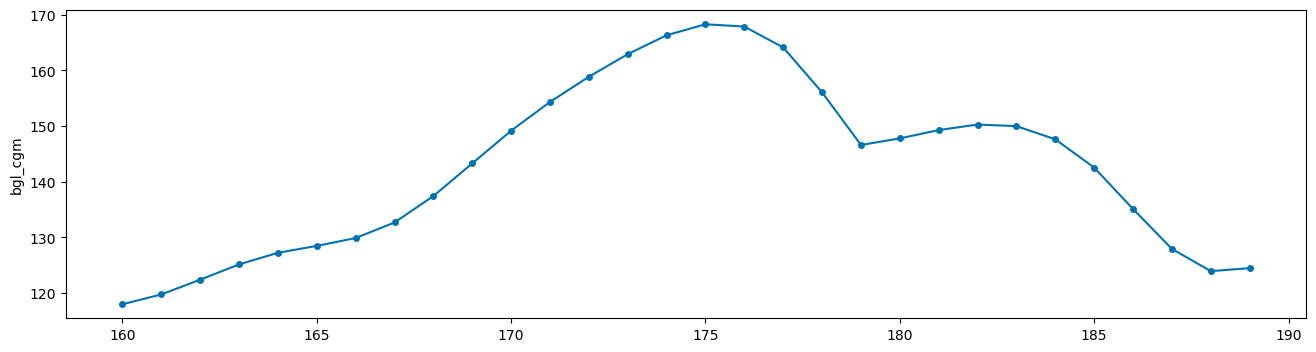

In [3]:
plot_series(df['bgl_cgm'][160:190])

### All change points (1 patient - 90 days):


In [4]:
df[df['meal_start_change_point'] == 'ANNOUNCE_MEAL'].index

Index([   29,   116,   164,   321,   373,   462,   606,   643,   670,   741,
       ...
       25223, 25271, 25392, 25424, 25506, 25672, 25700, 25746, 25763, 25795],
      dtype='int64', length=337)

Note that `bgl_cgm` should be used, not `bgl_real`. `bgl_cgm` adds realistic noise the simulated `bgl_real` data.

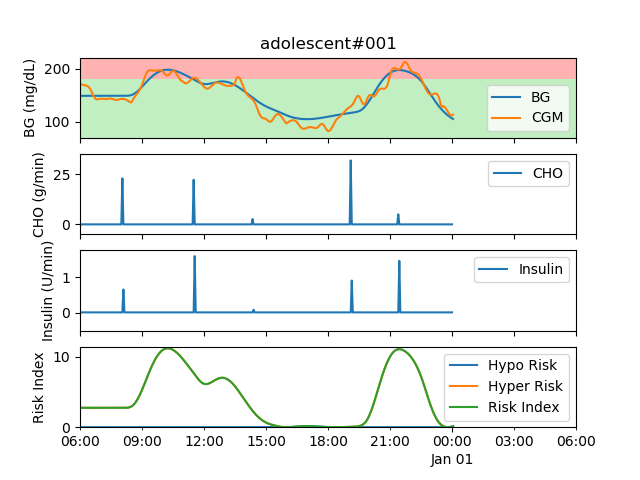

[Image Source](https://github.com/jxx123/simglucose/blob/master/screenshots/animate.png)

## Challenge Background

### Prandial Blood Glucose Dynamics Goals in Type 1 Diabetes 
Type 1 Diabetes (T1D) is a medical condition where the pancreas produces little to no insulin, the hormone that regulates blood glucose levels. 
Managing T1D for most is immensely challenging, the main goal is a delicate balance between:
1. Maximizing Time in Range (3.9mmol/L - 10.0 mmo/L blood glucose levels (BGL)),
2. Minimizing the short term risks caused by hypoglycemia (when BGL < 3.9mmol/L)
3. Minimizing the likelihood of [diabetes distress](https://www.diabetes.ca/about-diabetes-(3)/impact-stories/distressed-by-diabetes) or "diabetes burnout".
   
The best strategies to maximize TIR and minimize hypoglycemia risks usually involve meticulous tracking of:
- carbohydrates consumed, 
- the amount of insulin taken before the meal, and 
- the timing of the preprandial insulin dose.

Other notes:
- Insulin must be administered for nearly every meal that contains more than a 5-10g of carbs (exact amount varys by individual). 
- Generally, it is not recommended that T1Ds discontinue consumption of carbohydrates, or risk [diabetic ketoacidosis](https://www.mayoclinic.org/diseases-conditions/diabetic-ketoacidosis/symptoms-causes/syc-20371551). 
- Meticulously logging every meal causes cognitive burden that increases the likelihood of diabetes distress. 

When observed outside of the context of the mental burden of meal tracking, it leads to improved outcomes, it becomes much easier to estimate the correct timing and dosage quantity of insulin that will maximize your TIR if you have a detailed log because you can see how much insulin you took for similar previous meals.

### Diabetes Distress 
Common questions evaluated on the [diabetes distress scale](https://diabetes.ca/DiabetesCanadaWebsite/media/Health-care-providers/2018%20Clinical%20Practice%20Guidelines/the-DDS-with-scoring-recommendations.pdf?ext=.pdf) where diabetics are asked to rate the following questions on a 6 point scale from *Not a Problem* to *A Very Serious Problem* (quoted from linked resource):

1. Feeling that diabetes is taking up too much of my mental and physical energy every day.
2. Not feeling confident in my day-to-day ability to manage diabetes.
3. Feeling that I am often failing with my diabetes routine. 
4. Feeling that diabetes controls my life. 
5. Feeling that I am not sticking closely enough to a good meal plan.
6. Feeling overwhelmed by the demands of living with diabetes. 
7. Not feeling motivated to keep up my diabetes self management. 

### Goal of the Benchmark
The focus of this benchmark is to provide a real-world usecase for creating tools that alleviate diabetes distress. 

A significant amount of research in the diabetes community now focuses on ways of reducing the severity and likelihood of diabetes distress. 

- Our question is, what tools can we develop to make the logging of meals more streamlined and automated? 
- Using a stream of data from [continuous glucose monitors (CGM)](https://www.niddk.nih.gov/health-information/diabetes/overview/managing-diabetes/continuous-glucose-monitoring), can we reliably and automatically identify meals in a blood glucose time series dataset? 
- Possible usecases of this would be gentle notifications to the user at the end of a day identifying possible unlabelled meals, with a prepopulated change point log.

The outcome 

- diabetics would have a more richly detailed meal log, with a reduced cognitive burden, 
- researchers would have improved datasets that could lead to improvements in other downstream tasks like probabilistic hypoglycemic forecasting. 

 


## The Challenges with this Task

### Histogram of Meal Times
Meal times for many patients are highly irregular, even for habitual individuals (like below) the distributions have high variance, we cannot rely completely on prior historical data to predict when meals occur:

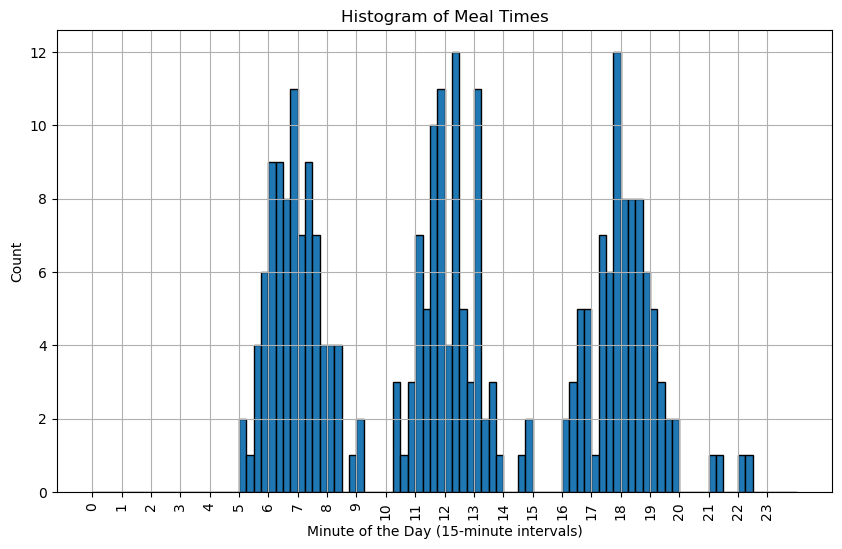


### Meal vs Non-Meal Blood Glucose Dynamics
This meal vs. non-meal distributions contain significant overlaps, being able to detect change points must rely on temporal dynamics.

#### Percentile Plots

##### Blood Glucose Levels
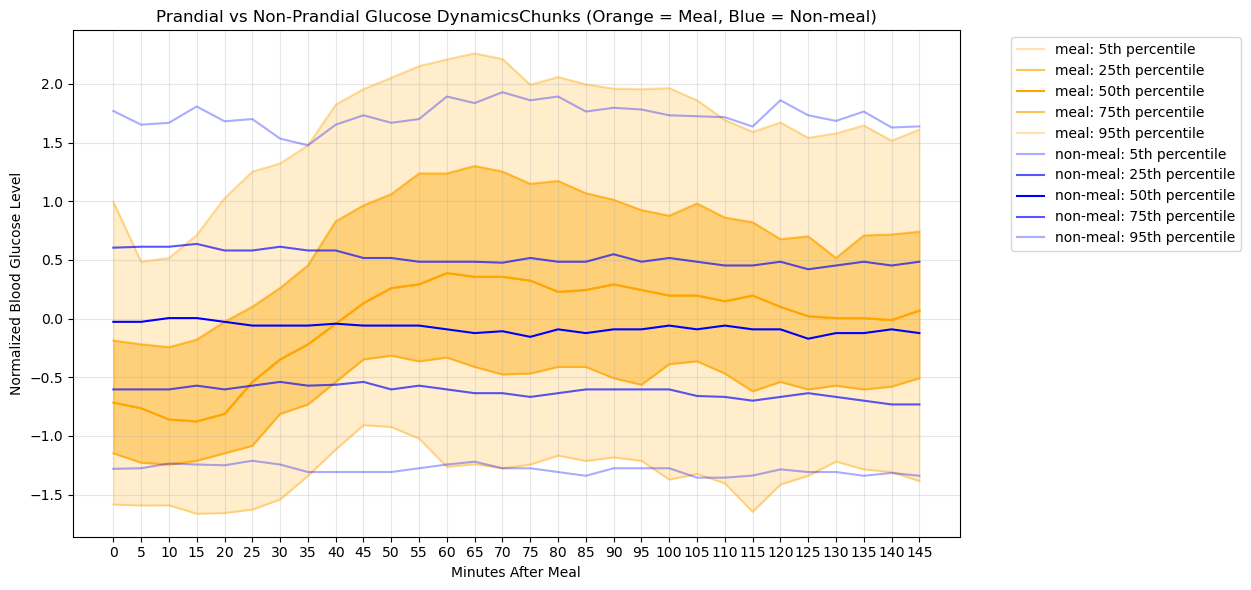


##### First Differences (Rate of Change)

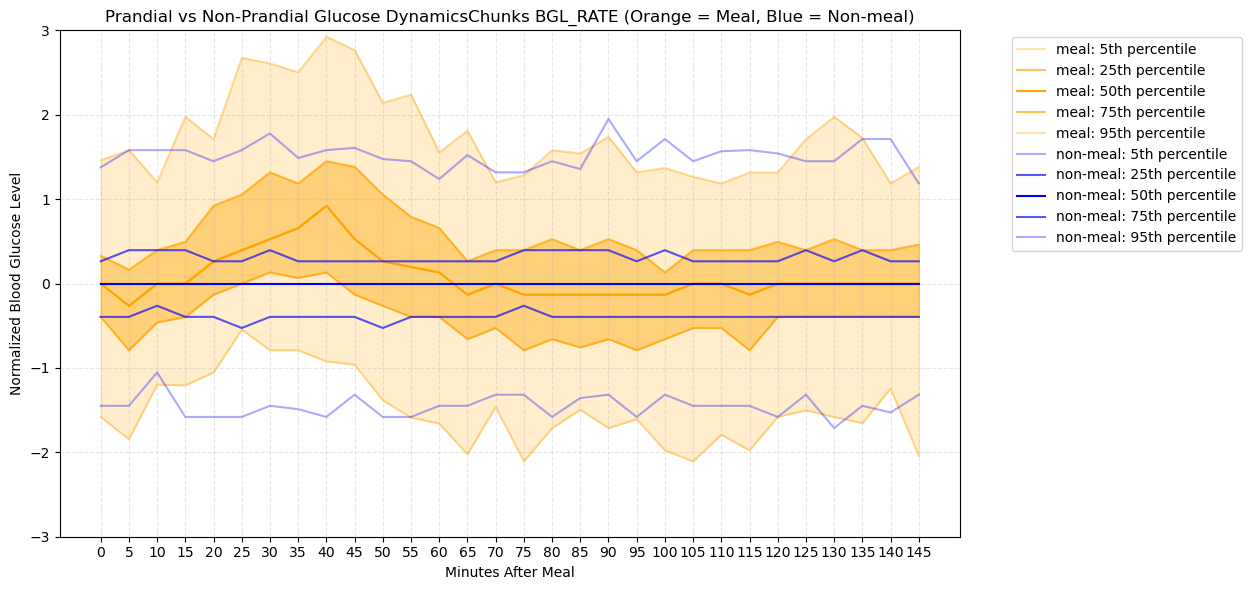

#### Fan Plots

Normalization through elementwise subtraction of the 0th element of each array.


##### Blood Glucose Levels

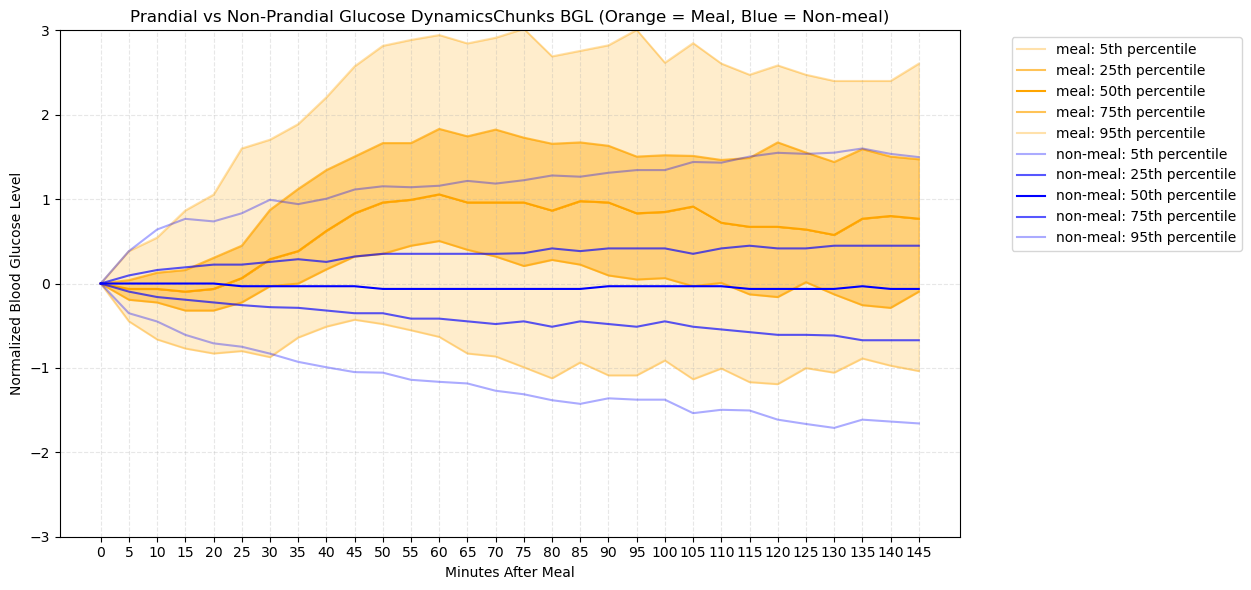



##### First Differences (Rate of Change)

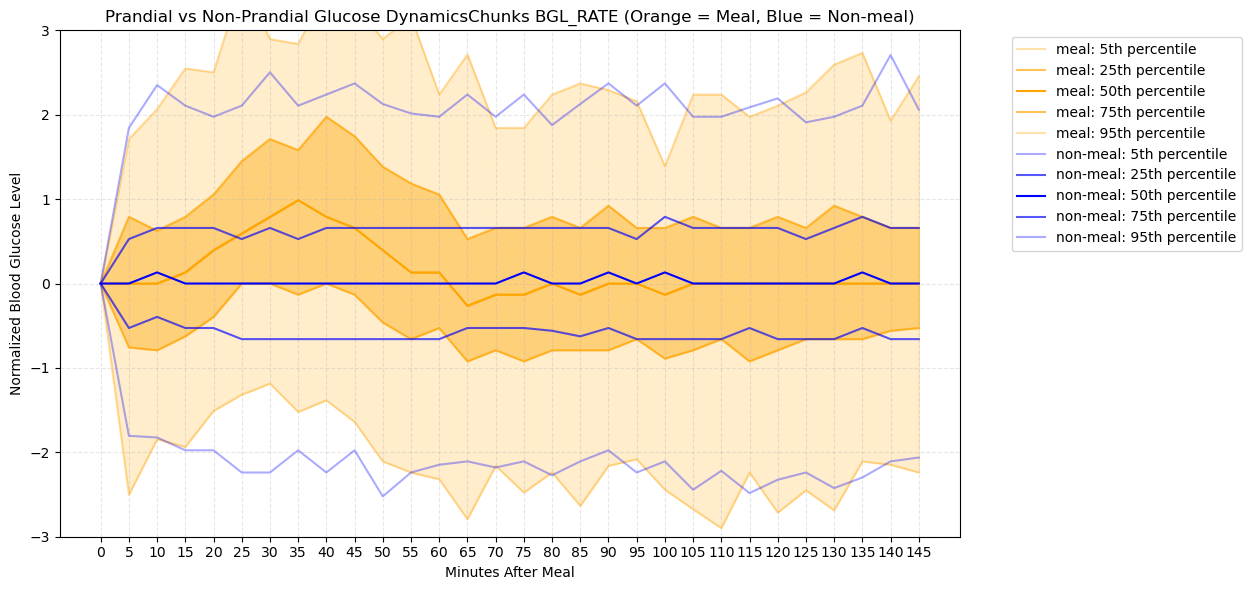


### Evaluation Metrics

We are in the process of adding the following evaluation metrics to the detector module of `sktime`

- RAND INDEX: the average similarity between the predicted breakpoint set and the ground truth. [Source: Section 3.2.3](https://www.sciencedirect.com/science/article/pii/S0165168419303494?via%3Dihub)

- F1-Score (change point). [Source: Section 3.2.4](https://www.sciencedirect.com/science/article/pii/S0165168419303494?via%3Dihub)
  -  **Precision** is the proportion of predicted change points that are true change points.
  -  **Recall** is the proportion of true change points that are well predicted.
  -  A breakpoint is considered detected up to a user-defined margin of error $M > 0$; 
  -  true positives $T_p$ are true change points for which there is an estimated one at less than $M$ samples.

## Conclusion

Data is generated using a python implementation of an FDA approved T1D simulator:

> Jinyu Xie. Simglucose v0.2.1 (2018) [Online]. Available: https://github.com/jxx123/simglucose. Accessed on: Nov-27-2024.

Python implementation is based on:

> [Man CD, Micheletto F, Lv D, Breton M, Kovatchev B, Cobelli C. The UVA/PADOVA Type 1 Diabetes Simulator: New Features. Journal of Diabetes Science and Technology. 2014;8(1):26-34. doi:10.1177/1932296813514502](https://journals.sagepub.com/doi/10.1177/1932296813514502)

The completed benchmark will: 

1. Modify the simulated data to be based off of real world semi-supervised unlabelled data rates. 
   - Patients meal logging habits will vary into logging multiple meals per day, once per day, every other day, a few times per week, to never. 
   - Ideally we can learn enough information from the frequent loggers to be able to identify meals for all types of users. 
2. Create the temporal train/test data split
3. Additional benchmarking challenges to evaluate transfer learning settings, 
   1. adult -> child, 
   2. manufacturer1_sensor_type -> manufacturer2_sensor_type, 
   3. manufacturer1_pump -> manufacturer2_pump
4. Create automatic benchmarking evaluator with the sktime api


## Expected Release

Expect the release of v1.0.0 of the benchmark in early 2025!